# Summary

Our log gamma function has negligible error for $0 < z < 100$ when compared to that of scipy's, but runs ~7X **slower** than scipy for large arrays ($10^7$ elements). The log gamma function is used as a coefficient in the Beta and Student-t PDF's, both of which have negligible Hellinger distance when compared to scipy. Our Beta and Student-t PDFs also run ~10X and ~20X  **faster** respectively than that of scipy's for large arrays ($10^7$ elements).

We compute $\log \left(\Gamma(x) \right)$ instead of $\Gamma(x)$ for all calculations as the latter can blow up and cause numerical overflow even for moderate $x$. As the Beta and Student-t PDF's include coefficients that are quotients of $\Gamma(x)$, we can simplify this by a difference of logs and then take the exponent of the result. This is much more numerically stable.


### Benchmarking

All comparisons are made against scipy.

* Log gamma absolute and relative errors are computed for $10,000$ points in the range $0<z<100$
* PDF comparisons are made using the [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance)
* Hellinger distances are computed $10,000$ times `(n_trials)` as follows
    - Beta PDF: $10,000$ points `(n_points)` in the range $0<x<1$ with $\alpha$ and $\beta$ sampled uniformaly at random in the range $0.1<\alpha,\beta<50$ each trial
    - Student-t PDF: $10,000$ points `(n_points)` in the range $-40<x<40$ with $\nu$ sampled uniformly at random in the range $1<\nu<50$ each trial

Finally, we compare PDF runtimes for varying array sizes from $10^0$ to $10^7$ while fixing input parameters.

In [1]:
import numpy as np
from numpy import log, exp, power, sqrt, pi, absolute
from numba import njit
from scipy.special import gammaln
from scipy import stats
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# define error measures

@njit
def rel_err(x_true, x_est):
    """
    Relative error between a
    true value `x_true` and estimated
    value `x_est`
    """
    d = absolute(x_true - x_est)
    out = d / x_true
    return out

@njit
def abs_err(x_true, x_est):
    """
    Absolute error between a
    true value `x_true` and estaimated
    value `x_est`
    """
    out = absolute(x_true - x_est)
    return out

@njit(fastmath=True)
def hellinger(p, q):
    """
    Hellinger distance between two
    probability distributions `p` and `q`
    """
    out = 0
    n = p.shape[0]
    for i in range(n):
        u = sqrt(p[i]) - sqrt(q[i])
        u = power(u, 2)
        out += u
    out = sqrt(0.5 * out)
    return out

In [3]:
GAMMA_COEFS = np.array([
    57.1562356658629235, -59.5979603554754912,
    14.1360979747417471, -0.491913816097620199,
    .339946499848118887e-4, .465236289270485756e-4,
    -.983744753048795646e-4, .158088703224912494e-3,
    -.210264441724104883e-3, .217439618115212643e-3,
    -.164318106536763890e-3, .844182239838527433e-4,
    -.261908384015814087e-4, .368991826595316234e-5
])

@njit(fastmath=True)
def gammaln_nr(z):
    """
    Log Gamma function.
    
    Returns Log of the Gamma function for
    all `z` > 0; gammaln_nr(z) = (z-1)!
    
    Given in Numerical Recipes 6.1
    """
    y = z
    tmp = z + 5.24218750000000000
    tmp = (z + 0.5) * log(tmp) - tmp
    ser = np.ones_like(y) * 0.999999999999997092
    
    n = GAMMA_COEFS.shape[0]
    for j in range(n):
        y = y + 1
        ser = ser + GAMMA_COEFS[j] / y
    
    out = tmp + log(2.5066282746310005 * ser / z)
    return out

@njit(fastmath=True)
def beta_pdf(x, alpha, beta):
    """
    Beta Probability Density Function.
    
    Beta PDF across `x` for parameters
    `a` and `b`
    """
    u = gammaln_nr(alpha + beta) - gammaln_nr(alpha) - gammaln_nr(beta)
    u = exp(u)
    v = power(x, alpha - 1) * power(1 - x, beta - 1)
    out = u * v
    return out

@njit(fastmath=True)
def t_pdf(x, nu):
    """
    Student-t Probability
    Density Function.
    
    t PDF across `x` for
    degrees of freedom `nu`
    """
    u = gammaln_nr(0.5 * (nu + 1)) - gammaln_nr(0.5 * nu)
    u = exp(u)
    v = sqrt(nu * pi) * power(1 + power(x, 2) / nu, 0.5 * (nu + 1))
    out = u / v
    return out

# Log Gamma Error

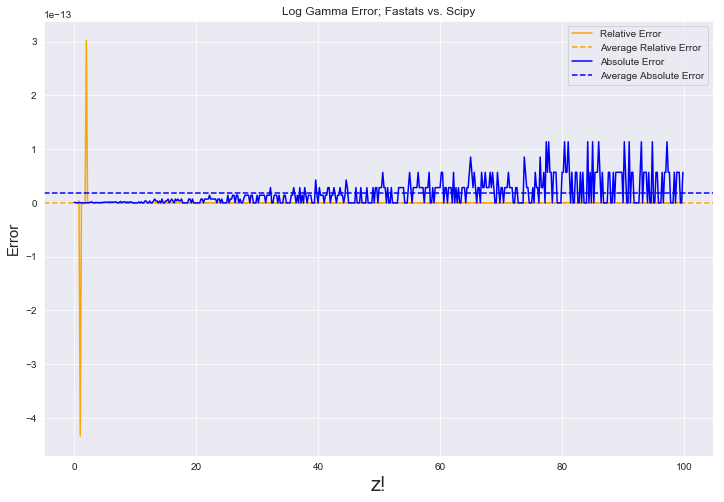

In [4]:
zs = np.linspace(0.001, 100, 10000)
errs = np.zeros((len(zs),2))

xnm = gammaln_nr(zs) # fastats
xsc = gammaln(zs) # scipy
errs[:,0] = rel_err(xsc, xnm)
errs[:,1] = abs_err(xsc, xnm)

fig, ax = plt.subplots(figsize=(12,8));
sns.lineplot(zs[::20], errs[:,0][::20], label="Relative Error", color='orange');
ax.axhline(y=errs[:,0].mean(), label="Average Relative Error", color="orange", linestyle="--");
sns.lineplot(zs[::20], errs[:,1][::20], label="Absolute Error", color="blue");
ax.axhline(y=errs[:,1].mean(), label="Average Absolute Error", color="blue", linestyle="--");
ax.set_title("Log Gamma Error; Fastats vs. Scipy")
ax.set_ylabel("Error", fontsize=15)
ax.set_xlabel("z!", fontsize=20)
ax.legend();

# Log Gamma Execution Time

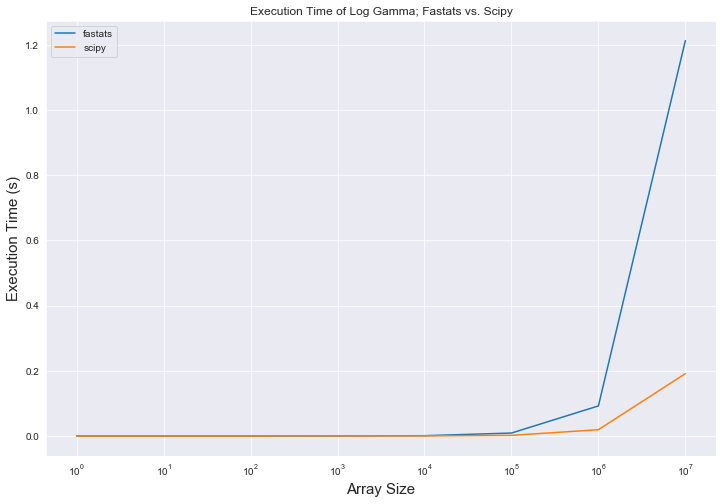

In [5]:
n_trials = 8
scipy_times = np.zeros(n_trials)
fastats_times = np.zeros(n_trials)

for i in range(n_trials):
    zs = np.linspace(0.001, 100, 10**i) # evaluate gammaln over this range

    # dont take first timing - this is just compi
    start = time.time()
    gammaln_nr(zs)
    end = time.time()

    start = time.time()
    gammaln_nr(zs)
    end = time.time()
    fastats_times[i] = end - start

    start = time.time()
    gammaln(zs)
    end = time.time()
    scipy_times[i] = end - start

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(np.logspace(0, n_trials-1, n_trials), fastats_times, label="fastats");
sns.lineplot(np.logspace(0, n_trials-1, n_trials), scipy_times, label="scipy");
ax.set(xscale="log");
ax.set_xlabel("Array Size", fontsize=15);
ax.set_ylabel("Execution Time (s)", fontsize=15);
ax.set_title("Execution Time of Log Gamma; Fastats vs. Scipy");

In [6]:
# our log gamma function is still 2X faster for single values ;)
z = np.random.uniform(1,100)
print(z)
%timeit gammaln_nr(z)
%timeit gammaln(z)

20.148913136951766
403 ns ± 0.946 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
887 ns ± 4.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Beta PDF

### Hellinger Distance

Choose $\alpha$ and $\beta$ randomly for each trial

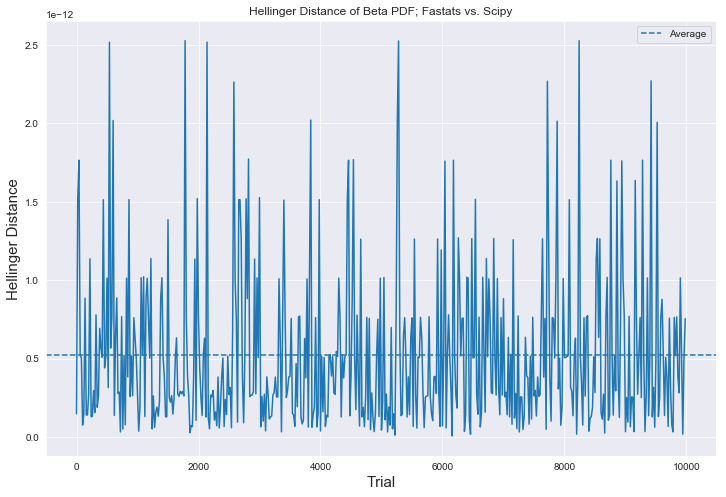

In [7]:
n_points = 10000
zs = np.linspace(0.001, 0.999, n_points) # beta only defined on interval 0<x<1
n_trials = 10000
hellinger_dists = np.zeros(n_trials)
alphas = np.random.uniform(0.1, 50, n_trials)
betas = np.random.uniform(0.1, 50, n_trials)

for i in range(n_trials):
    xfs = beta_pdf(zs, alphas[i], betas[i])
    xsc = stats.beta(a=alphas[i], b=betas[i]).pdf(zs)
    hellinger_dists[i] = hellinger(xfs, xsc)

fig, ax = plt.subplots(figsize=(12,8));
sns.lineplot(np.arange(n_trials)[::20], hellinger_dists[::20]); # plot every 20th point
ax.axhline(y=hellinger_dists.mean(), label="Average", linestyle="--");

ax.set_title("Hellinger Distance of Beta PDF; Fastats vs. Scipy")
ax.set_ylabel("Hellinger Distance", fontsize=15)
ax.set_xlabel("Trial", fontsize=15)
ax.legend();

### Execution Time

Fix $\alpha$ and $\beta$ for all array sizes

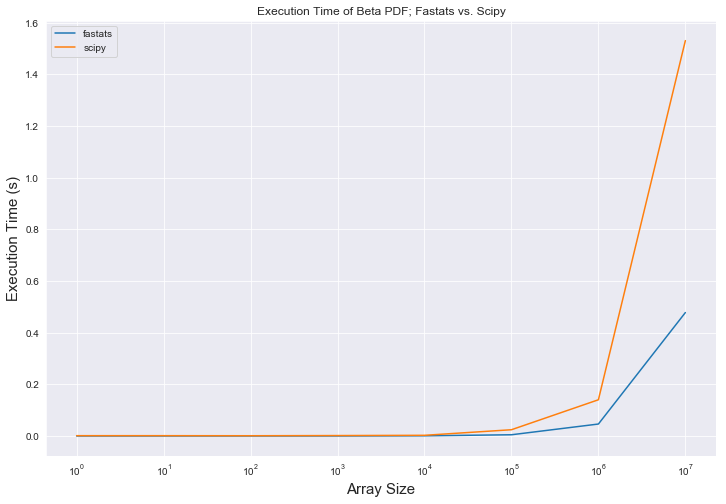

In [8]:
n_trials = 8
scipy_times = np.zeros(n_trials)
fastats_times = np.zeros(n_trials)
alpha = 4
beta = 7

for i in range(n_trials):
    zs = np.linspace(0.001, 0.999, 10**i) # beta only defined on interval 0<x<1

    start = time.time()
    beta_pdf(zs, alpha, beta)
    end = time.time()

    start = time.time()
    beta_pdf(zs, alpha, beta)
    end = time.time()
    fastats_times[i] = end - start

    start = time.time()
    stats.beta(a=alpha, b=beta).pdf(zs)
    end = time.time()
    scipy_times[i] = end - start

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(np.logspace(0, n_trials-1, n_trials), fastats_times, label="fastats");
sns.lineplot(np.logspace(0, n_trials-1, n_trials), scipy_times, label="scipy");
ax.set(xscale="log");
ax.set_xlabel("Array Size", fontsize=15);
ax.set_ylabel("Execution Time (s)", fontsize=15);
ax.set_title("Execution Time of Beta PDF; Fastats vs. Scipy");

# Student-t PDF

### Hellinger Distance

Choose $\nu$ randomly for each trial

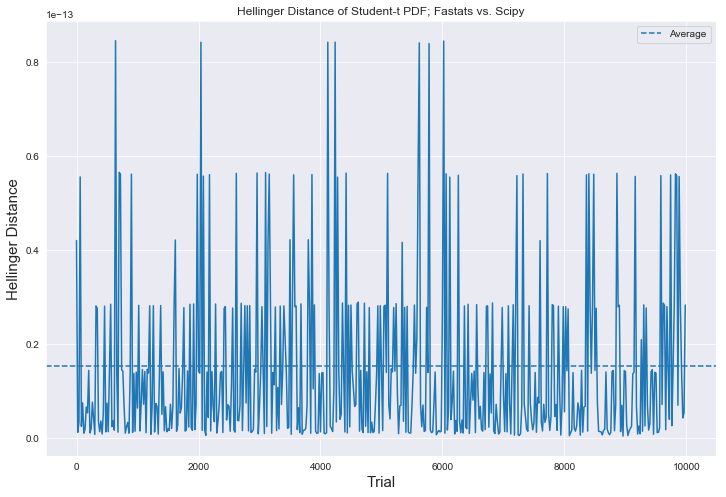

In [9]:
n_points = 10000
zs = np.linspace(-40, 40, n_points) # t defined on whole real line
n_trials = 10000
hellinger_dists = np.zeros(n_trials)
nus = np.random.uniform(1, 50, n_trials)

for i in range(n_trials):
    xfs = t_pdf(zs, nus[i])
    xsc = stats.t(df=nus[i]).pdf(zs)
    hellinger_dists[i] = hellinger(xfs, xsc)

fig, ax = plt.subplots(figsize=(12,8));
sns.lineplot(np.arange(n_trials)[::20], hellinger_dists[::20]); # plot every 20th point
ax.axhline(y=hellinger_dists.mean(), label="Average", linestyle="--");

ax.set_title("Hellinger Distance of Student-t PDF; Fastats vs. Scipy")
ax.set_ylabel("Hellinger Distance", fontsize=15)
ax.set_xlabel("Trial", fontsize=15)
ax.legend();

### Execution Time

Fix $\nu$ for all array sizes

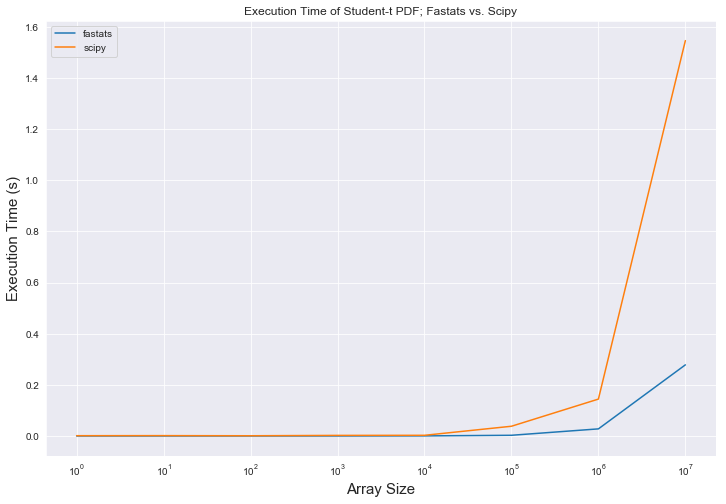

In [10]:
n_trials = 8
scipy_times = np.zeros(n_trials)
fastats_times = np.zeros(n_trials)
nu = 5

for i in range(n_trials):
    zs = np.linspace(-40, 40, 10**i)

    start = time.time()
    t_pdf(zs, nu)
    end = time.time()

    start = time.time()
    t_pdf(zs, nu)
    end = time.time()
    fastats_times[i] = end - start

    start = time.time()
    stats.t(df=nu).pdf(zs)
    end = time.time()
    scipy_times[i] = end - start

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(np.logspace(0, n_trials-1, n_trials), fastats_times, label="fastats");
sns.lineplot(np.logspace(0, n_trials-1, n_trials), scipy_times, label="scipy");
ax.set(xscale="log");
ax.set_xlabel("Array Size", fontsize=15);
ax.set_ylabel("Execution Time (s)", fontsize=15);
ax.set_title("Execution Time of Student-t PDF; Fastats vs. Scipy");

# Conclusion

Our Log Gamma function is extremely accurate for $0 < z < 100$, with both relative error and absolute error almost always $<10^{-13}$. The Log Gamma run time is ~7X slower than scipy's for large arrays.

Our Beta and Student-t PDF's have negligible Hellinger distance; $<10^{-12}$ and $<10^{-13}$ on average respectively. Our PDF execution times are always less than that of scipy's. For large arrays, with $10^7$ elements, this can be ~10X for Beta PDF and ~20X for Student-t faster than scipy.